# Downloading data from Kaggle

In this section I download the kaggle module on the machine, and the .zip file of the dataset. After that I create a folder and unzip the needed files there

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"maksymlytovka","key":"54cd404c9e9594179ea8c3d6df1a189c"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          37308       1049  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           5861        153  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           7609        161  1.0              
mohithsairamreddy/salary-data 

In [ ]:
! kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [24:39<00:00, 20.0MB/s]
100% 28.6G/28.6G [24:39<00:00, 20.7MB/s]


In [ ]:
! mkdir airbus-ship-detection

In [ ]:
! unzip airbus-ship-detection.zip -d airbus-ship-detection


Streaming output truncated to the last 5000 lines.
  inflating: airbus-ship-detection/train_v2/f9775b70e.jpg  
  inflating: airbus-ship-detection/train_v2/f977a470c.jpg  
  inflating: airbus-ship-detection/train_v2/f9780bfaf.jpg  
  inflating: airbus-ship-detection/train_v2/f9782bdfe.jpg  
  inflating: airbus-ship-detection/train_v2/f9785ca49.jpg  
  inflating: airbus-ship-detection/train_v2/f9785e462.jpg  
  inflating: airbus-ship-detection/train_v2/f97a719d5.jpg  
  inflating: airbus-ship-detection/train_v2/f97afa376.jpg  
  inflating: airbus-ship-detection/train_v2/f97b85e3e.jpg  
  inflating: airbus-ship-detection/train_v2/f97bd0b11.jpg  
  inflating: airbus-ship-detection/train_v2/f97bd6b80.jpg  
  inflating: airbus-ship-detection/train_v2/f97bfb1b2.jpg  
  inflating: airbus-ship-detection/train_v2/f97c8cbbe.jpg  
  inflating: airbus-ship-detection/train_v2/f97cdd397.jpg  
  inflating: airbus-ship-detection/train_v2/f97d92e1e.jpg  
  inflating: airbus-ship-detection/train_v2/f97da

# Import and constants

In [ ]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import gc; gc.enable()

directory_path = "airbus-ship-detection"
train_path = os.path.join(directory_path, 'train_v2')
test_path = os.path.join(directory_path, 'test_v2')

In [ ]:
BATCH_SIZE = 4
EDGE_CROP = 16
# Number of epochs
NB_EPOCHS = 150
# The coefficient of Gaussian noise added
# on the 1st layer of the CNN
GAUSSIAN_NOISE = 0.1
# Downsampling inside the network
# If you want to scale down the image,
# please input tuple with the resolution
NET_SCALING = None
# Downsampling (scaling) in preprocessing
IMG_SCALING = (1, 1)
# Number of validation images to use
VALID_IMG_COUNT = 600
# Maximum number of steps per epoch in training
MAX_TRAIN_STEPS = 200

# Needed encoding/decoding functions

The functions for Run-Length decoding and encoding

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

# This one will be needed further to decode pixels into an image.
# It decodes ALL masks of the image in one go.
def masks_as_image(in_mask_list: np.array):
    '''
    Takes the list of the masks (ships) and create a single mask array for all ships.
    Returns numpy array, in which 0 element is a needed encoding (1 - mask, 0 - background)
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list: # going throug all masks
        if isinstance(mask, str):
            # if mask in str type, then decode and add
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

# Importing data

In [ ]:
masks = pd.read_csv(os.path.join(directory_path, 'train_ship_segmentations_v2.csv'))
masks.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [ ]:
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], "unique ImageId's")

231723 masks found
192556 unique ImageId's


From that we can see the encoding used. As ids are repeating, we have one ship per row, but not one image per row

In [ ]:
masks['ImageId'].value_counts()

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

This piece of code confirms my assumption

Just taking a look into the data here

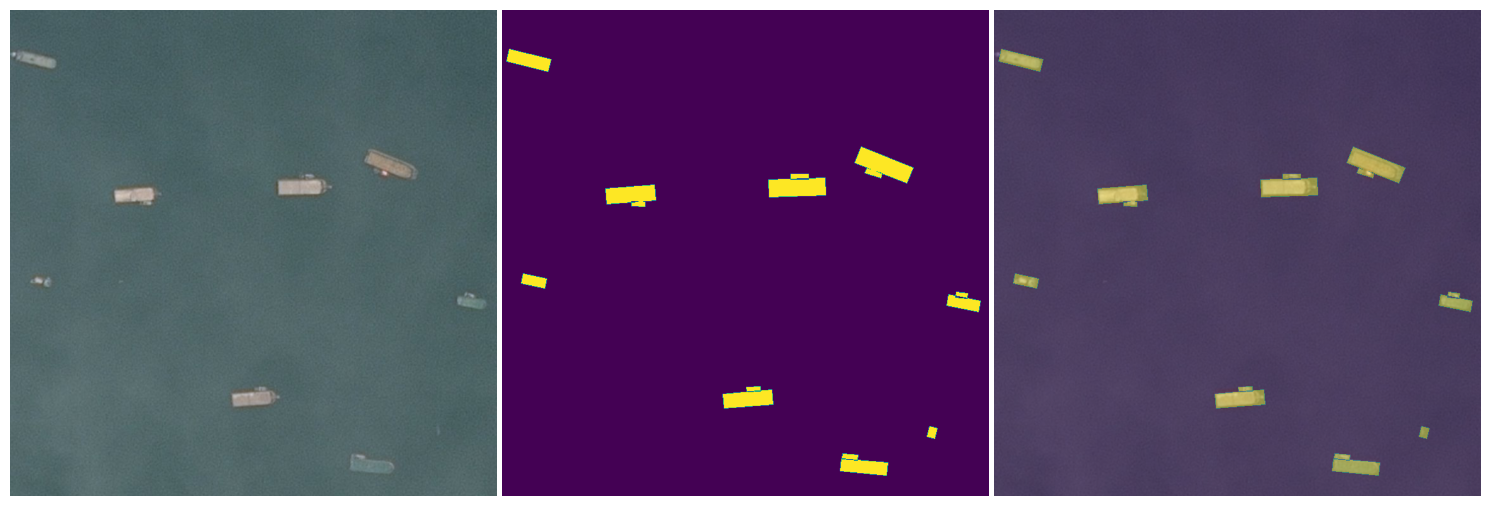

In [ ]:
photo_id = 'c8e722430.jpg'
photo_ships = imread(os.path.join(train_path, photo_id))
photo_ships_masks = masks.loc[masks['ImageId'] == photo_id, 'EncodedPixels'].tolist()

mask_array = np.zeros((768, 768))
for mask in photo_ships_masks:
    mask_array += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(photo_ships)
axarr[1].imshow(mask_array)
axarr[2].imshow(photo_ships)
axarr[2].imshow(mask_array, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.4)
plt.show()

# Splitting into train and validation set

ImageId  ships  has_ship has_ship_vec  file_size_kb
161679  d70582b99.jpg      3       1.0        [1.0]    128.152344
125302  a6af421b3.jpg      0       0.0        [0.0]    114.157227
161492  d6c99405f.jpg      0       0.0        [0.0]    110.388672
129440  ac2613ba4.jpg      0       0.0        [0.0]    219.538086
132470  b01b89de0.jpg      0       0.0        [0.0]    125.381836

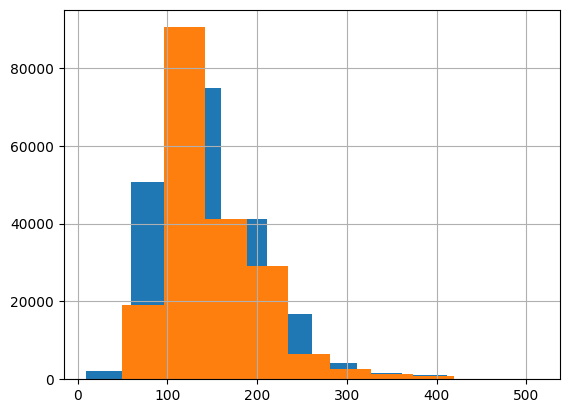

In [ ]:
# creating a new column with the indication thether there are ship on the picture (1) or no (0)
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
# creating a new DataFrame, in which information is grouped by the id of the image
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
# we create a new column with the 1 if image has ships on it and 0 otherwise
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x]) # same as prev. but list (vector)
# filter files that are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join(train_path,
                                                                                    c_img_id)).st_size/1024)

unique_img_ids['file_size_kb'].hist() # before filtering (blue)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
# That's because if file weights less than 50, it is probably corrupted
unique_img_ids['file_size_kb'].hist() # after filtering (orange)
# The difference in histograms occured due to the matplotlib's way of
# showing the data
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified sampling based on the number of ships
# Note, that we are sampling the id's of the images
# and not the masks themselve. That's because
# every mask is one ship, and if we sample basing
# on ships data will be messed up
train_ids, valid_ids = train_test_split(unique_img_ids,
                 test_size = 0.2,
                 stratify = unique_img_ids['ships'])

# JOIN with the previous dataframes
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

184071 training masks
46011 validation masks


In [ ]:
train_df['ImageId'].value_counts()

d193c1f59.jpg    15
73361816c.jpg    15
c446d13fe.jpg    15
405b98f45.jpg    15
41bdd5164.jpg    15
                 ..
592a9a178.jpg     1
592a49517.jpg     1
59296a06f.jpg     1
5929364e7.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 153031, dtype: int64

In [ ]:
train_df.head()

ImageId                                      EncodedPixels  ships  \
0  0001124c7.jpg                                                NaN      0   
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1   
2  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5   
3  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      5   
4  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      5   

   has_ship has_ship_vec  file_size_kb  
0       0.0        [0.0]     76.059570  
1       1.0        [1.0]    147.625977  
2       1.0        [1.0]     75.221680  
3       1.0        [1.0]     75.221680  
4       1.0        [1.0]     75.221680

<Axes: >

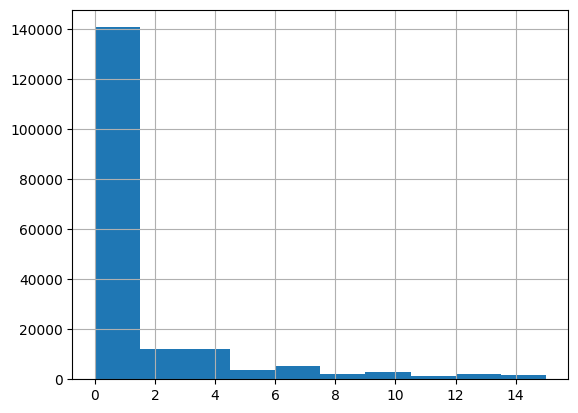

In [ ]:
train_df['ships'].hist()

# Undersample 0-images (no ships)

In the dataset we have to much samples with no ships. Therefore, we undersample it.\
Note, that I forgot to change the rate of undersampling from 10 to smaller number (3-4) in the row:


```
return in_df.sample(base_rep_val//10)
```

But it did not affected the network significantly, so it's fine :)\
However, it **was changed** in the .py file with for training the model.

In [ ]:
train_df['strat_group'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)

def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].iloc[0] == 0:
        return in_df.sample(base_rep_val//10) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))

balanced_train_df = train_df.groupby('strat_group').apply(sample_ships)
balanced_train_df['ships']

strat_group        
0            119480     0
             95298      0
             66761      0
             40529      0
             126437     0
                       ..
7            124898    15
             90981     13
             2821      14
             121543    15
             45958     15
Name: ships, Length: 10650, dtype: int64

<Axes: >

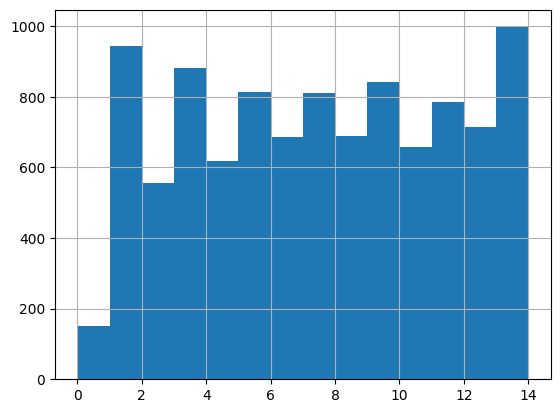

In [ ]:
balanced_train_df['ships'].hist(bins=np.arange(15))

Just checking the data here. As we can see, 0-ships pictures too much undersampled (oops..)

In [ ]:
for i in range(8):
    n_df = balanced_train_df.loc[balanced_train_df["strat_group"] == i]
    print('{}-th group:'.format(i), n_df['ImageId'].shape[0])

0-th group: 150
1-th group: 1500
2-th group: 1500
3-th group: 1500
4-th group: 1500
5-th group: 1500
6-th group: 1500
7-th group: 1500


<Axes: >

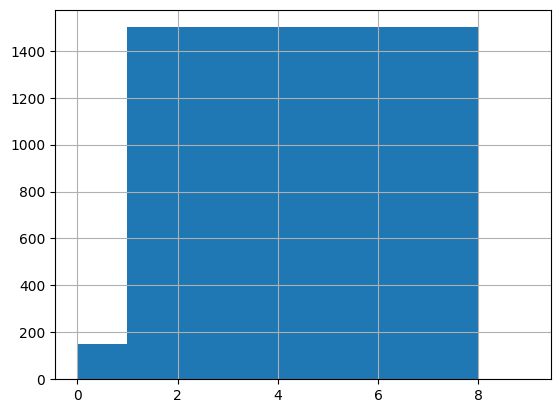

In [ ]:
balanced_train_df['strat_group'].hist(bins=np.arange(10))

In [ ]:
balanced_train_df.sample(10)

ImageId  \
strat_group                         
3           103184  8ef2866a7.jpg   
4           109600  97e862924.jpg   
            49022   444db3028.jpg   
            62133   564141353.jpg   
5           166408  e77e71b8d.jpg   
2           26740   256b8f2e3.jpg   
3           126595  afb5c1de1.jpg   
6           43581   3d192187a.jpg   
4           156376  d98e531e0.jpg   
6           165373  e61c88e3b.jpg   

                                                        EncodedPixels  ships  \
strat_group                                                                    
3           103184  122113 1 122881 2 123649 2 124417 3 125185 3 1...      5   
4           109600  456210 19 456978 19 457746 19 458514 19 459282...      7   
            49022   401965 1 402732 3 403499 5 404267 7 405034 9 4...      7   
            62133   401446 7 402214 19 402982 25 403750 25 404518 ...      7   
5           166408  405938 2 406706 4 407473 7 408241 9 409008 12 ...     10   
2           26740   420029 2 420797 6 421565 8 422332 9 423100 9 4...      3   
3           126595  84765 1 85532 3 86300 4 87067 6 87834 8 88603 ...      5   
6           43581   233807 2 234571 6 235339 6 236107 7 236876 6 2...     11   
4           156376  366485 2 367251 4 368016 8 368781 11 369547 13...      7   
6           165373  191565 1 192332 4 193100 5 193867 8 194634 10 ...     11   

                    has_ship has_ship_vec  file_size_kb  strat_group  
strat_group                                                           
3           103184       1.0        [1.0]    154.929688            3  
4           109600       1.0        [1.0]    115.083008            4  
            49022        1.0        [1.0]    120.332031            4  
            62133        1.0        [1.0]    257.147461            4  
5           166408       1.0        [1.0]    160.485352            5  
2           26740        1.0        [1.0]    179.023438            2  
3           126595       1.0        [1.0]    147.980469            3  
6           43581        1.0        [1.0]    110.981445            6  
4           156376       1.0        [1.0]    117.874023            4  
6           165373       1.0        [1.0]    184.565430            6

# Decoding RLE into images (arrays)

Creating a generator for the images we will feed into the CNN

In [ ]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches: # current image, current masks
            rgb_path = os.path.join(train_path, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            # if we want to scale the images during the preprocessing
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

## Train images

Applying this generator to the train images to check whether everything is working properly

In [ ]:
mask_image_generator = make_image_gen(balanced_train_df)
train_x, train_y = next(mask_image_generator)
print('X', train_x.shape, train_x.min(), train_x.max())
print('Y', train_y.shape, train_y.min(), train_y.max())

X (4, 768, 768, 3) 0.0 1.0
Y (4, 768, 768, 1) 0 1


Printing to check the function

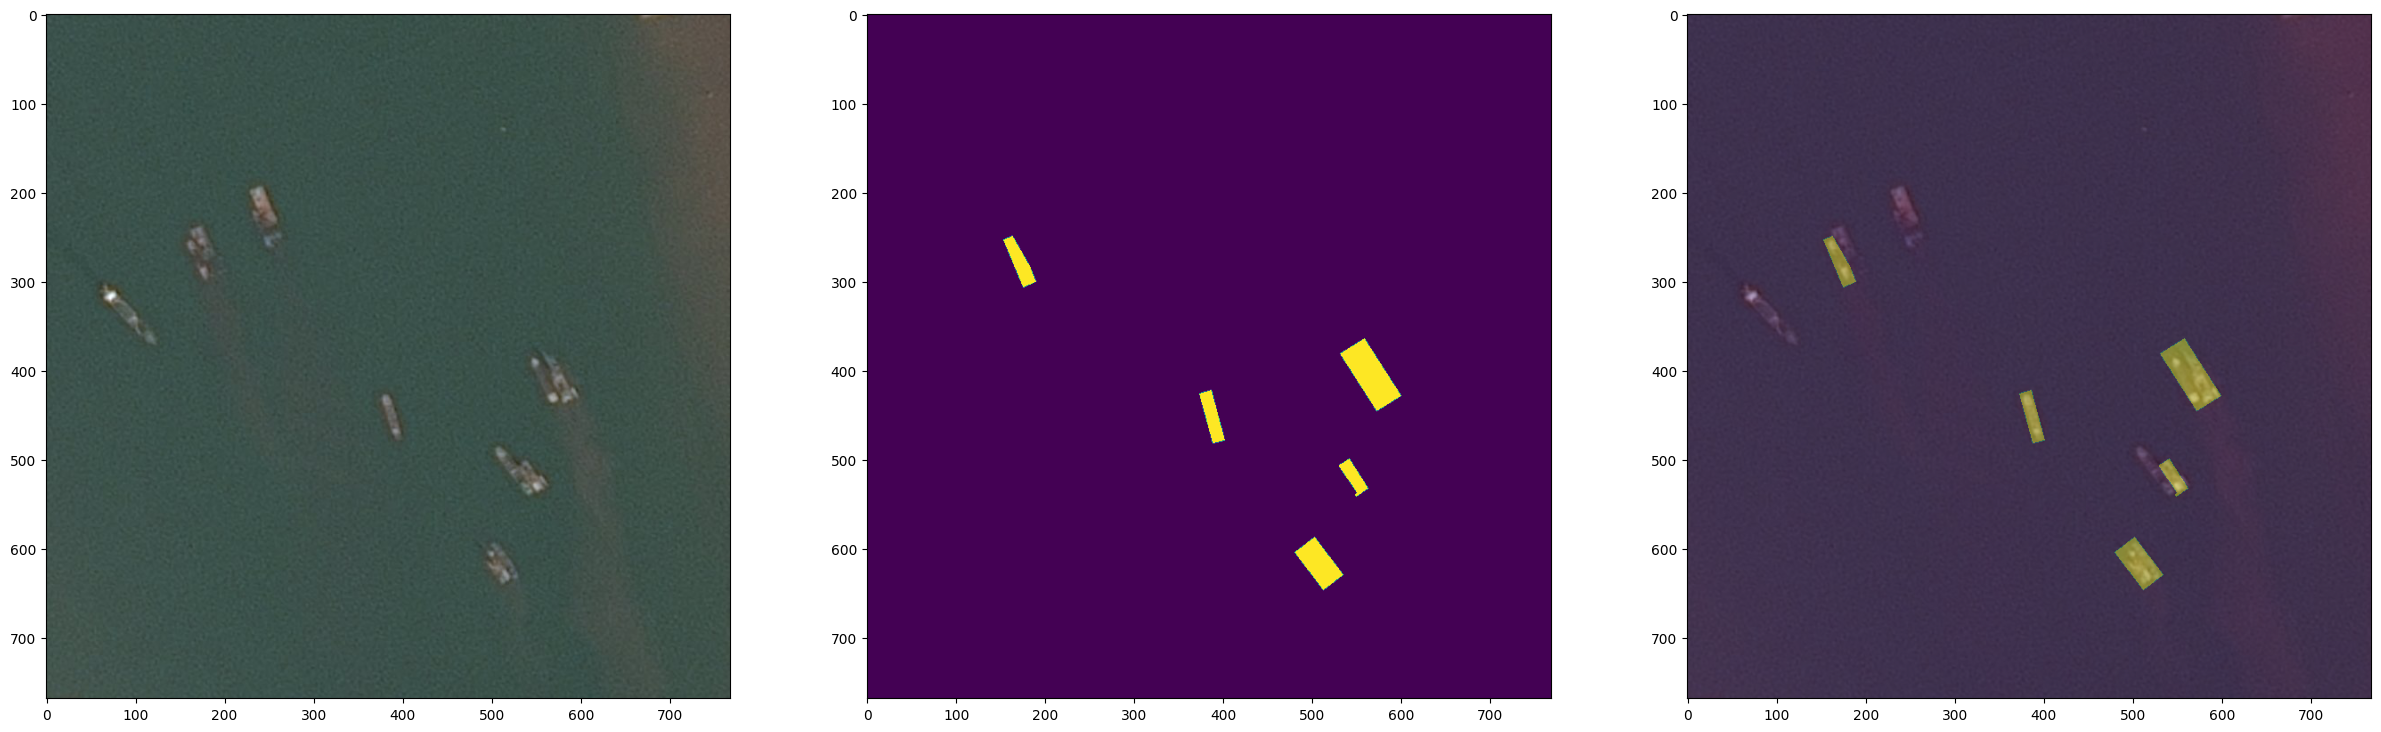

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
ax1.imshow(train_x[3])
ax2.imshow(train_y[3])
ax3.imshow(train_x[3])
ax3.imshow(train_y[3], alpha=0.4)

And here we already can see the problems with the data: not all ships are highlighted. It will has its negative effect on results of the network.\
So, Airbus, decoding information ship by row and not image by row is not the best idea now 😏

## Validation images

Applying it to the validation images. Note, that as well as batch size we may also controle the number of images on which we will do the validation (VALID_IMG_COUNT)

In [ ]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(600, 768, 768, 3) (600, 768, 768, 1)


# Data augmentation

We expand our dataset using Keras (Tensorflow) backend

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 15,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [ ]:
full_gen = create_aug_gen(mask_image_generator)
train_full_x, train_full_y = next(full_gen)

And we apply this augmentation generator only for the data for training. There is no need to do that for validation data as we can just increase the VALID_IMG_COUNT parameter

In [ ]:
print('x', train_full_x.shape, train_full_x.dtype, train_full_x.min(), train_full_x.max())
print('y', train_full_y.shape, train_full_y.dtype, train_full_y.min(), train_full_y.max())

x (4, 768, 768, 3) float32 0.0 0.9995028
y (4, 768, 768, 1) float32 0.0 1.0


Checking whether everything is working

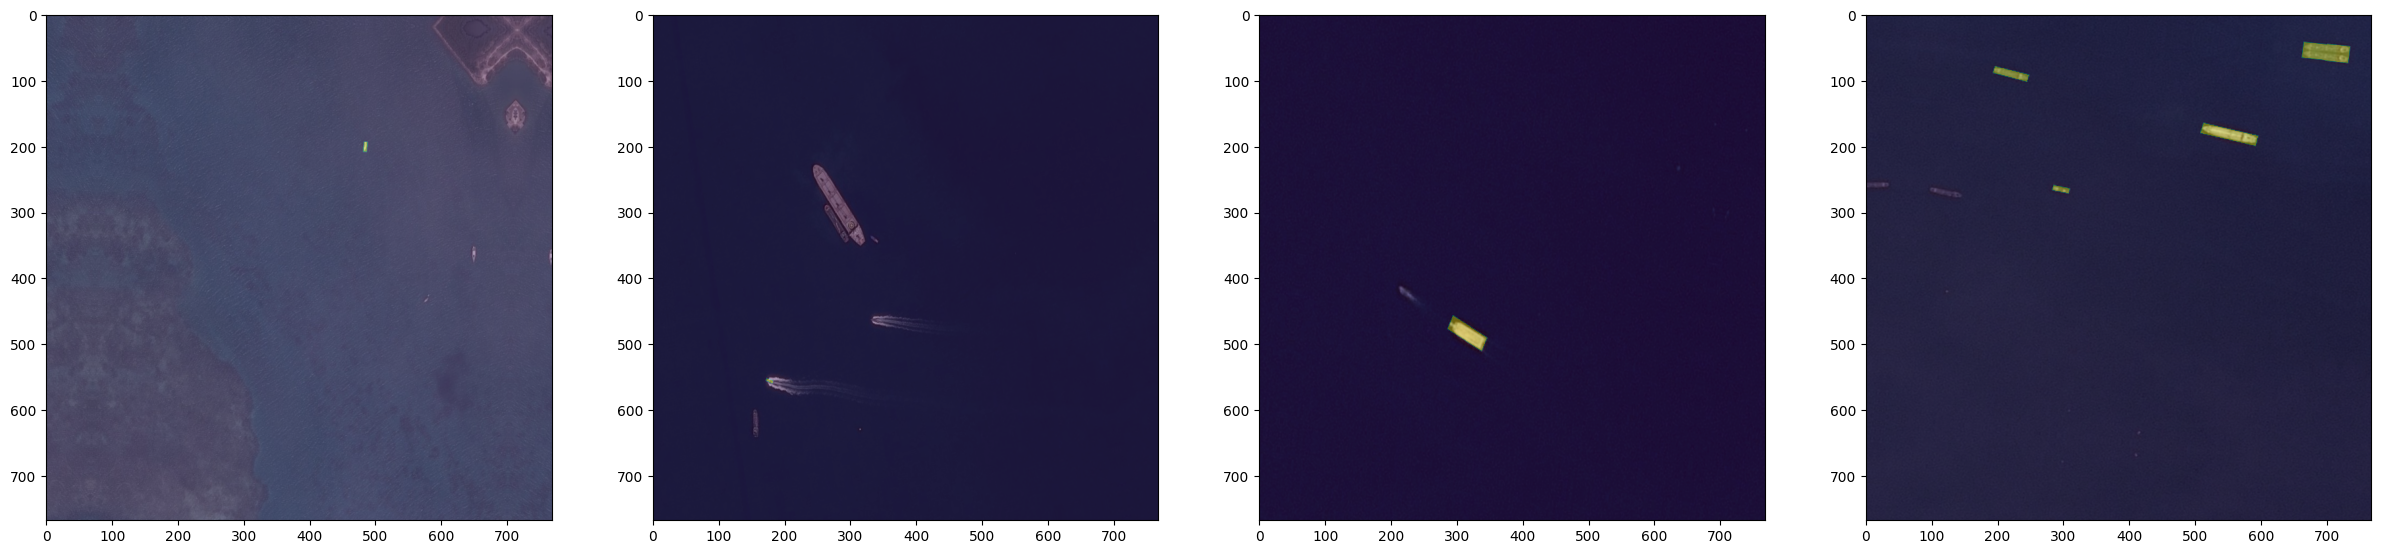

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (30, 10))
ax1.imshow(train_full_x[0])
ax1.imshow(train_full_y[0], alpha=0.4)
ax2.imshow(train_full_x[1])
ax2.imshow(train_full_y[1], alpha=0.4)
ax3.imshow(train_full_x[2])
ax3.imshow(train_full_y[2], alpha=0.4)
ax4.imshow(train_full_x[3])
ax4.imshow(train_full_y[3], alpha=0.4)

plt.show()

Again, we see the incompletness of the training data

In [ ]:
gc.collect()

5

# Model

The U-net model architecture

In [ ]:
from keras import models, layers


def upsample(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding=padding)


input_img = layers.Input(train_full_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

# This option if we want to scale image inside the model itself.
# May be useful if we have images of different sizes and don't
# want to do the preprocessing.
# However, in the competition dataset every image of the same size,
# so we don't really need it for now.
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

# Gaussian noise and batch normalization may help to regulize
# the data and improve predictions
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

# -------------- End of the downsampling

c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# -------------- Start of the upsampling

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 768, 768, 3)  0          ['RGB_Input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 768, 3)  12         ['gaussian_noise[0][0]']         
 alization)                                                                                       
                                                                                              

## Monitoring of the training

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf

# function that computes the dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    y_tr = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_tr * y_pred, axis=[1,2,3])
    union = K.sum(y_tr, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# The combined (by binary crossentropy and dice coefficient) loss function we
# will use.  We aim to capture both the localization accuracy of the segmentation
# masks (through dice coefficient) and the overall pixel-wise classification
# accuracy (through binary cross-entropy).
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# The file we will save the best weight in
weight_path="{}_weights.best.hdf5".format('seg_model')

# This callback will save the best weights on each step
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

# This callback will reduce the learning rate when we are entering plateau.
# Such a atrategy may improve mdoel predictions
reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

# This callback will stop the network training if we won't have any improvements
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=25)

callbacks_list = [checkpoint, early, reduceLROnPlat]

## Let's GO (training)

In [ ]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

In [ ]:
loss_history = [seg_model.fit(aug_gen,
                             steps_per_epoch=step_count,
                             epochs=NB_EPOCHS,
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                             workers=1
                                       )]

Epoch 1/150
200/200 [==============================] - ETA: 0s - loss: -0.0093 - dice_coef: 0.0098 - binary_accuracy: 0.9711 - true_positive_rate: 0.0673
Epoch 1: val_dice_coef improved from -inf to 0.00994, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 182s 850ms/step - loss: -0.0093 - dice_coef: 0.0098 - binary_accuracy: 0.9711 - true_positive_rate: 0.0673 - val_loss: -0.0097 - val_dice_coef: 0.0099 - val_binary_accuracy: 0.8358 - val_true_positive_rate: 0.3944 - lr: 1.0000e-04
Epoch 2/150
200/200 [==============================] - ETA: 0s - loss: -0.1118 - dice_coef: 0.1124 - binary_accuracy: 0.7503 - true_positive_rate: 0.5236
Epoch 2: val_dice_coef improved from 0.00994 to 0.27442, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 147s 741ms/step - loss: -0.1118 - dice_coef: 0.1124 - binary_accuracy: 0.7503 - true_positive_rate: 0.5236 - val_loss: -0.2740 - val_dice_coef: 0.2744 - val_binary_accuracy: 0.

## Results of the training

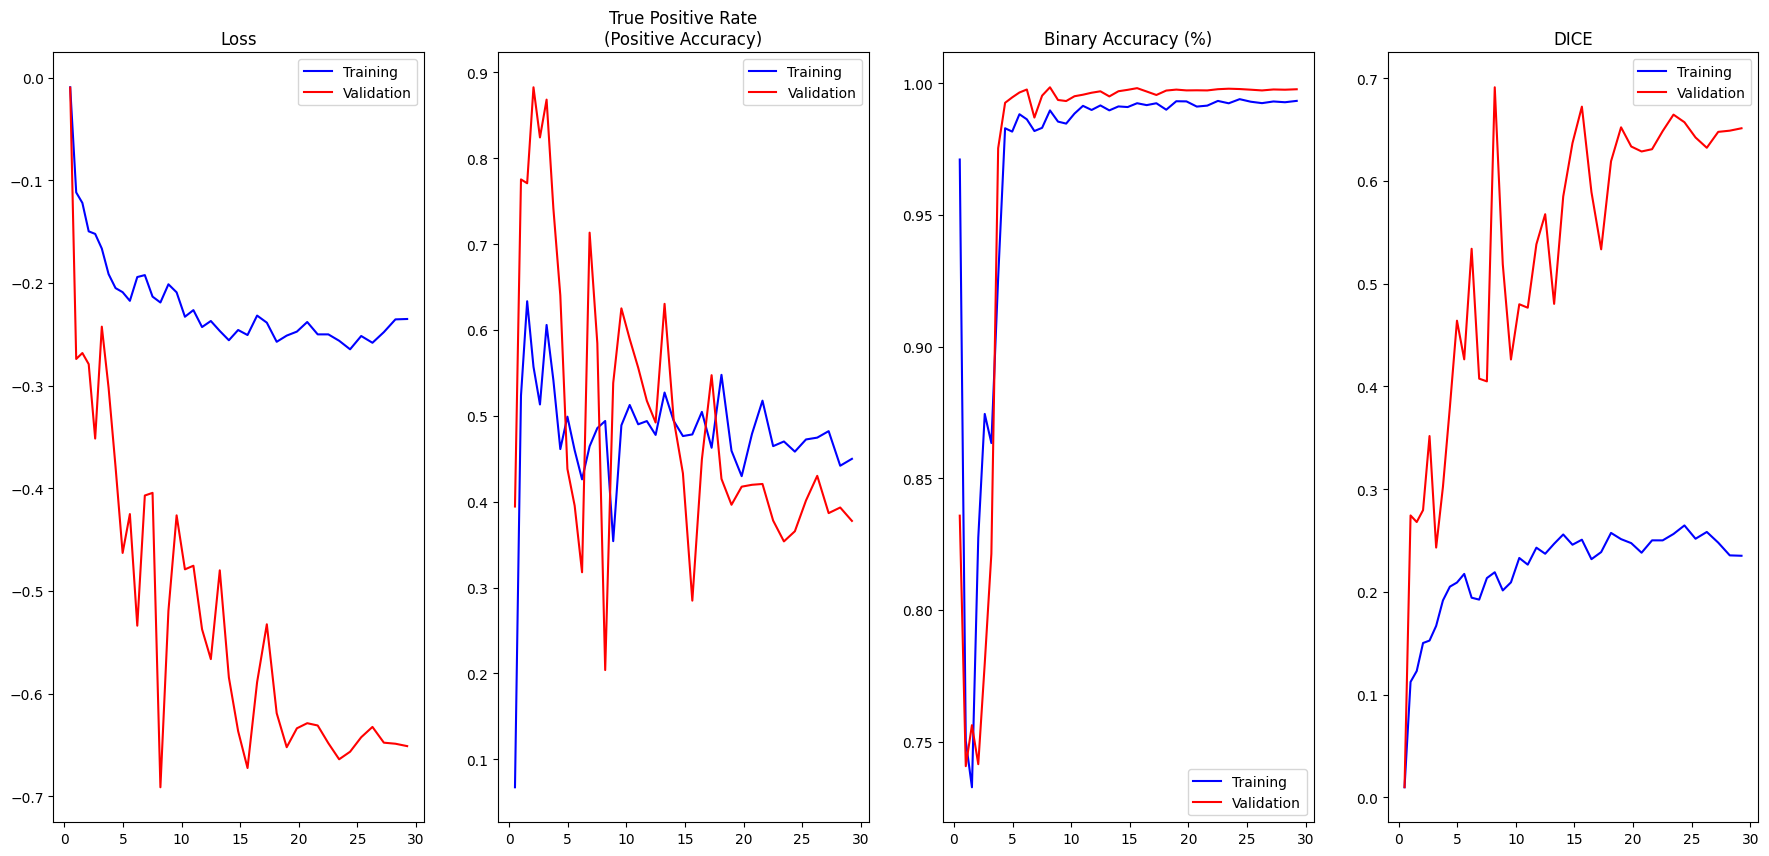

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')

    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')

    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

## Saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

### and any resolution model
In case we want to upload images of some other resolution. That way we will have scaling right inside the model

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model

fullres_model.save('fullres_model.h5')

In [ ]:
! cp kaggle.json  /content/drive/MyDrive
! cp seg_model.h5 /content/drive/MyDrive
! cp fullres_model.h5 /content/drive/MyDrive
! cp seg_model_weights.best.hdf5 /content/drive/MyDrive

# Importing the model

On this step I usually was run out of RAM to perform final validation and saving of the results. That is why I imported the model

In [ ]:
os.listdir()

['.config',
 'seg_model_weights.best.hdf5',
 'airbus-ship-detection',
 'seg_model.h5',
 'kaggle (1).json',
 'airbus-ship-detection.zip',
 'kaggle.json',
 'sample_data']

In [ ]:
from keras import models, layers


if not 'seg_model' in globals():
  seg_model = models.load_model('seg_model.h5', compile=False)
  seg_model.load_weights('seg_model_weights.best.hdf5')

# Valuation

Just a small final validation to take a look how the model works

In [ ]:
gc.collect()

946

In [ ]:
final_valid_x, final_valid_y = valid_x, valid_y

In [ ]:
final_valid_prediction = seg_model.predict(final_valid_x)

19/19 [==============================] - 16s 218ms/step


In [ ]:
final_valid_prediction

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
result = dice_coef(final_valid_y, final_valid_prediction,)

In [ ]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=0.6657356>

491491 1 491493 1 491495 762 492258 1 492260 1 492262 1 492264 759 493024 1 493026 1 493028 1 493030 1 493032 1 493034 757 493792 1 493794 1 493796 1 493798 1 493800 1 493802 355 494158 1 494160 1 494162 1 494164 393 494558 1 494560 1 494562 1 494564 1 494566 1 494568 1 494570 1 494572 1 494574 351 494926 1 494928 1 494930 1 494932 393 495326 1 495328 1 495330 1 495332 1 495334 1 495336 1 495338 1 495340 1 495342 1 495344 347 495692 1 495694 1 495696 1 495698 1 495700 1 495702 389 496092 1 496094 1 496096 1 496098 1 496100 1 496102 1 496104 1 496106 1 496108 1 496110 1 496112 1 496459 1 496461 1 496463 1 496465 1 496467 1 496469 1 496859 1 496861 1 496863 1 496865 1 496867 1 496869 1 496871 1 496873 1 496875 1 496877 1 496879 1 497225 1 497227 1 497229 1 497231 1 497233 1 497235 1 497237 1 497239 1 497627 1 497629 1 497631 1 497633 1 497635 1 497637 1 497639 1 497641 1 497643 1 497645 1 497647 1 497649 342 497992 1 497994 1 497996 1 497998 1 498000 1 498002 1 498004 1 498006 1 498008 3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: ignored

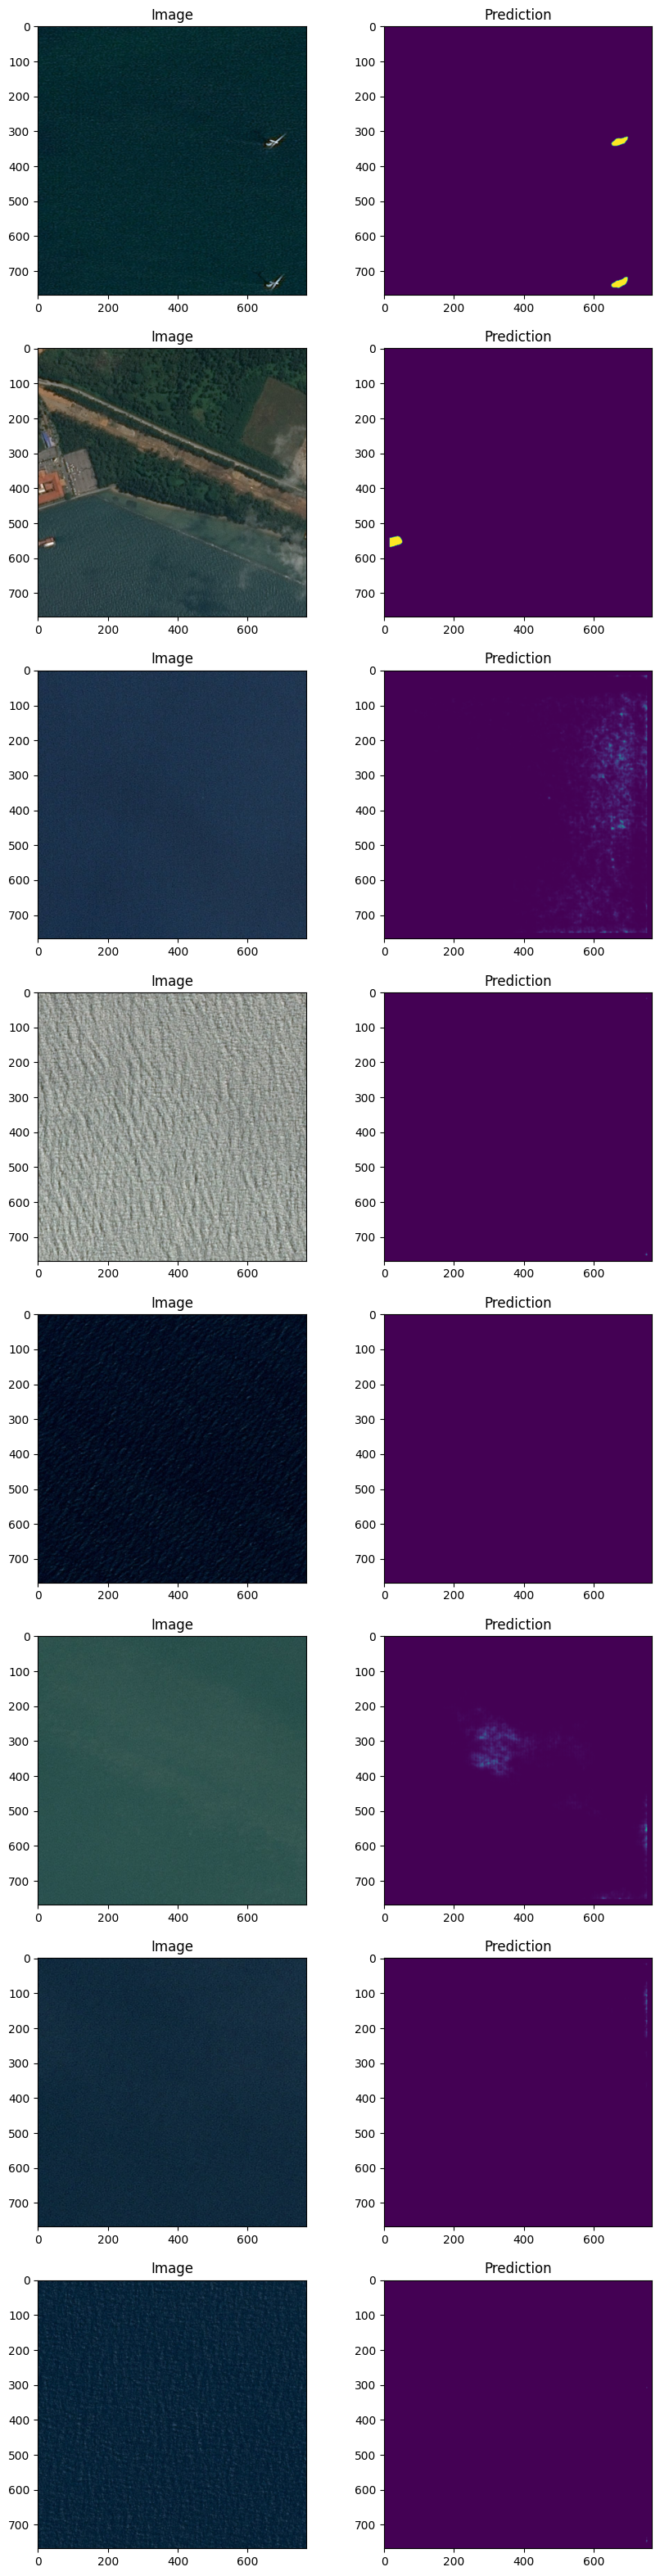

In [ ]:
fig, m_axs = plt.subplots(8, 2, figsize = (10, 40))

for (ax1, ax2), image, prediction in zip(m_axs, final_valid_x, final_valid_prediction):
    ax1.imshow(image)
    ax1.set_title('Image')
    ax2.imshow(prediction)
    ax2.set_title('Prediction')

fig.savefig('predictions_validation.png')

# Submission

This section deals with the submission of the results for the competition

In [ ]:
test_paths = os.listdir(test_path)
print(len(test_paths), 'test images found')

15606 test images found


In [ ]:
from tqdm import tqdm_notebook # for the nice visualisation
from skimage.morphology import binary_opening, disk # final results processing


out_pred_rows = []

for c_img_name in tqdm_notebook(test_paths):
    c_path = os.path.join(test_path, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = seg_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = rle_encode(cur_seg)
    if len(cur_rles)>0:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': cur_rles}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

<ipython-input-31-c5abbc164e9f>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for c_img_name in tqdm_notebook(test_paths):


  0%|          | 0/15606 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


In [ ]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)

In [ ]:
!cp submission.csv /content/drive/MyDrive

cp: cannot create regular file '/content/drive/MyDrive': No such file or directory


# Playground

The small section just to ensure that submission function works properly

In [ ]:
from skimage.morphology import binary_opening, disk
test_paths = os.listdir(test_path)


out = []

ImageId = test_paths[2107]

path = os.path.join(test_path, ImageId)
img = imread(path)

In [ ]:
img.shape

(768, 768, 3)

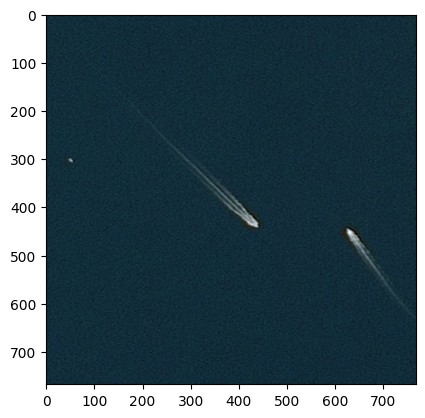

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img = np.expand_dims(img, 0)/255.0
cur_seg = seg_model.predict(img)[0]
cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
cur_rles = rle_encode(cur_seg)
if len(cur_rles)>0:
        out += [{'ImageId': ImageId, 'EncodedPixels': cur_rles}]
else:
    out += [{'ImageId': ImageId, 'EncodedPixels': None}]

1/1 [==============================] - 10s 10s/step


In [ ]:
out[0]

{'ImageId': 'c855c53d0.jpg',
 'EncodedPixels': '34862 4 35629 6 36396 8 37164 8 37931 9 38699 9 39468 8 40236 8 41005 7 41774 5 42543 1 42545 1 299916 2 300681 1 300683 5 301448 9 302215 11 302983 13 303751 16 304520 16 305289 16 306057 17 306825 17 307594 17 308363 16 309131 17 309900 17 310668 18 311437 18 312206 18 312975 18 313744 18 314513 19 315282 22 316051 23 316820 24 317589 25 318358 25 319127 25 319896 26 320665 26 321433 27 322202 27 322971 27 323740 26 324508 27 325277 26 326045 27 326814 26 327583 25 328351 26 329120 26 329889 25 330658 24 331427 23 332196 22 332965 21 333734 20 334503 19 335272 18 336041 17 336810 15 337579 13 338348 11 339119 7 473539 7 474305 11 475071 15 475838 17 476605 19 477372 21 478139 23 478907 24 479674 26 480442 27 481210 28 481978 29 482746 30 483514 30 484282 30 485051 30 485819 31 486587 31 487356 30 488124 31 488892 32 489661 31 490430 30 491199 29 491967 29 492736 28 493505 27 494274 26 495043 25 495812 24 496581 23 497351 22 498120 21 49

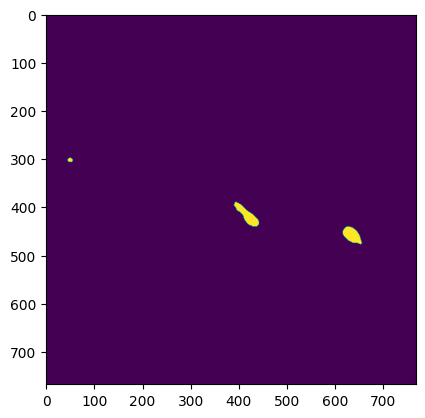

In [ ]:
plt.imshow(cur_seg)
plt.show()

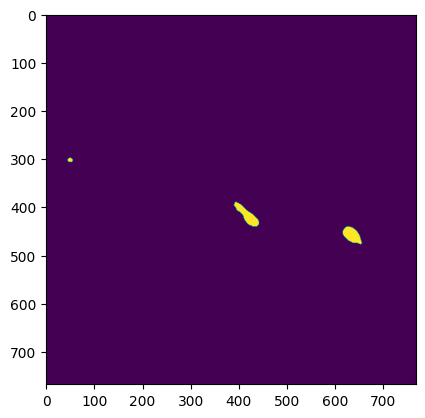

In [ ]:
plt.imshow(rle_decode(rle_encode(cur_seg)))
plt.show()